#1. Load data and inspect basic discription

In [105]:
# Enable the display of matplotlib plots directly in the notebook (useful for Jupyter notebooks).

%matplotlib inline


 ## 1.1 Load data

In [106]:
#Load data
import pandas as pd
df = pd.read_csv("/Users/svitlanakovalivska/automotive_car_price_estimator/data/cars.csv")
df.head()

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,mazda,2,5500,2008,with mileage,162000.0,petrol,1500.0,burgundy,mechanics,front-wheel drive,B
1,mazda,2,5350,2009,with mileage,120000.0,petrol,1300.0,black,mechanics,front-wheel drive,B
2,mazda,2,7000,2009,with mileage,61000.0,petrol,1500.0,silver,auto,front-wheel drive,B
3,mazda,2,3300,2003,with mileage,265000.0,diesel,1400.0,white,mechanics,front-wheel drive,B
4,mazda,2,5200,2008,with mileage,97183.0,diesel,1400.0,gray,mechanics,front-wheel drive,B


In [107]:
#Data shape
df.shape

(56244, 12)

In [108]:
#Unique values
df.nunique()

make                     96
model                  1034
priceUSD               2970
year                     78
condition                 3
mileage(kilometers)    8400
fuel_type                 3
volume(cm3)             458
color                    13
transmission              2
drive_unit                4
segment                   9
dtype: int64

In [109]:
#Check the data types
df.dtypes

make                    object
model                   object
priceUSD                 int64
year                     int64
condition               object
mileage(kilometers)    float64
fuel_type               object
volume(cm3)            float64
color                   object
transmission            object
drive_unit              object
segment                 object
dtype: object

We need to convert data into the proper formats to prepare the dataset for analysis and modeling

In [110]:
#Rename Columns (for consistency & easier access)
df = df.rename(columns={
    'priceUSD': 'price',
    'mileage(kilometers)': 'mileage_km',
    'volume(cm3)': 'volume_cm3'
})

## 1.2. Convert Data Types

In [111]:
# Convert to category (saves memory and signals discrete values)
categorical_cols = ['make', 'model', 'condition', 'fuel_type', 'color',
                    'transmission', 'drive_unit', 'segment']
df[categorical_cols] = df[categorical_cols].astype('category')

# Ensure numeric columns are of correct type
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['mileage_km'] = pd.to_numeric(df['mileage_km'], errors='coerce')
df['volume_cm3'] = pd.to_numeric(df['volume_cm3'], errors='coerce')


In [112]:
#Check the data types
df.dtypes

make            category
model           category
price              int64
year               int64
condition       category
mileage_km       float64
fuel_type       category
volume_cm3       float64
color           category
transmission    category
drive_unit      category
segment         category
dtype: object

In [113]:
#Convert Engine Volume to Liters
df['volume_liters'] = df['volume_cm3'] / 1000
df = df.drop(columns='volume_cm3')


## 1.3. Data exploration and visualization with ProfileReport

In [114]:
pip install -q ydata-profiling

Note: you may need to restart the kernel to use updated packages.


In [115]:
from ydata_profiling import ProfileReport

# Generate the EDA report
profile = ProfileReport(df, title="Car Pricing EDA Report", explorative=True)

# Save it as an HTML file
profile.to_file("car_pricing_eda.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 184.75it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Here’s a breakdown of the key insights from your `car_pricing_eda.html` profile report and recommendations for handling missing values:

---

**1. Missing Values Overview**
- **`segment`**: 9.4% missing (5291 entries)
- **`drive_unit`**: 3.4% missing (1905 entries)
- **`volume_liters`**: 47 missing entries (very small proportion)

---

**2. Distribution & Outliers**
`volume_liters`:
- **Highly skewed (Skewness = 8.34, Kurtosis = 130.99)**: Indicates extreme outliers.
- **IQR (Interquartile Range)**: 0.7
- **Recommendation**: Use **median imputation** due to skewed distribution.

 `segment`:
- Strongly correlated with `drive_unit`, `transmission`, and `price`
- Since this is categorical with **manual annotations**, you may:
  - Use **mode imputation** (most common value)
  - Or apply a **predictive imputation model** (e.g., classification model using `make`, `drive_unit`, etc.)

 `drive_unit`:
- Also categorical with moderate missingness
- Highly correlated with `make`, `segment`, and `transmission`
- **Recommendation**:
  - If `make` and `transmission` are present, use them to impute missing `drive_unit` (e.g., via decision tree or mode grouped by these features)

---

  **3. Alerts & Additional Notes**
- `make` and `model` have **high cardinality** (96 and 1034 unique values respectively), be cautious when using them for encoding or imputation
- `price` is highly **right-skewed (Skewness = 5.14, Kurtosis = 59.59)** → use **robust models** and consider **log transformation** for better predictions

---

 **Imputation Strategy Summary**
| Feature         | Type       | Recommended Strategy         | Reasoning                                      |
|----------------|------------|------------------------------|-----------------------------------------------|
| `volume_liters`| Numeric    | Median                       | Skewed, outliers present                      |
| `drive_unit`   | Categorical| Mode or Model-based          | Correlated with `make`, `segment`             |
| `segment`      | Categorical| Mode or Model-based          | Manual entry, moderate correlation            |

If you'd like, I can also help script the imputation or create visual summaries of the distributions. Just let me know!

## 1.4. Check for Duplicates

In [116]:
# Total duplicated rows
print("Duplicates:", df.duplicated().sum())

# Optionally drop them
df = df.drop_duplicates()


Duplicates: 87


## 1.5. Inspect and Clean Categorical Typos / Inconsistencies

In [117]:
# Unique values in each
for col in ['make', 'model', 'fuel_type', 'transmission', 'drive_unit', 'segment']:
    print(f"\nUnique values in {col}:", df[col].unique())



Unique values in make: ['mazda', 'mg', 'renault', 'gaz', 'aro', ..., 'iran-khodro', 'zotye', 'tagaz', 'saipa', 'brilliance']
Length: 96
Categories (96, object): ['acura', 'alfa-romeo', 'aro', 'asia', ..., 'vortex', 'wartburg', 'zaz', 'zotye']

Unique values in model: ['2', '3', '5', '6', '9', ..., 'z300', 'z4', 'zafira', 'zdx', 'zeta']
Length: 1034
Categories (1034, object): ['1-seriya', '100', '1007', '100nx', ..., 'z4', 'zafira', 'zdx', 'zeta']

Unique values in fuel_type: ['petrol', 'diesel', 'electrocar']
Categories (3, object): ['diesel', 'electrocar', 'petrol']

Unique values in transmission: ['mechanics', 'auto']
Categories (2, object): ['auto', 'mechanics']

Unique values in drive_unit: ['front-wheel drive', NaN, 'rear drive', 'all-wheel drive', 'part-time four-wheel drive']
Categories (4, object): ['all-wheel drive', 'front-wheel drive', 'part-time four-wheel drive', 'rear drive']

Unique values in segment: ['B', 'C', NaN, 'M', 'D', 'E', 'A', 'J', 'S', 'F']
Categories (9, obj

In [118]:
# Convert the 'make' and 'model' columns to lowercase and removes leading/trailing spaces to standardize text formatting.

df['make'] = df['make'].str.lower().str.strip()
df['model'] = df['model'].str.lower().str.strip()

/var/folders/t0/f0dxth6149d03d5n4n024r6h0000gn/T/ipykernel_4270/9604223.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/t0/f0dxth6149d03d5n4n024r6h0000gn/T/ipykernel_4270/9604223.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



For categorical-categorical associations like this, a correlation matrix with Cramér’s V is more appropriate than Pearson’s correlation.

In [119]:
!pip install -q researchpy


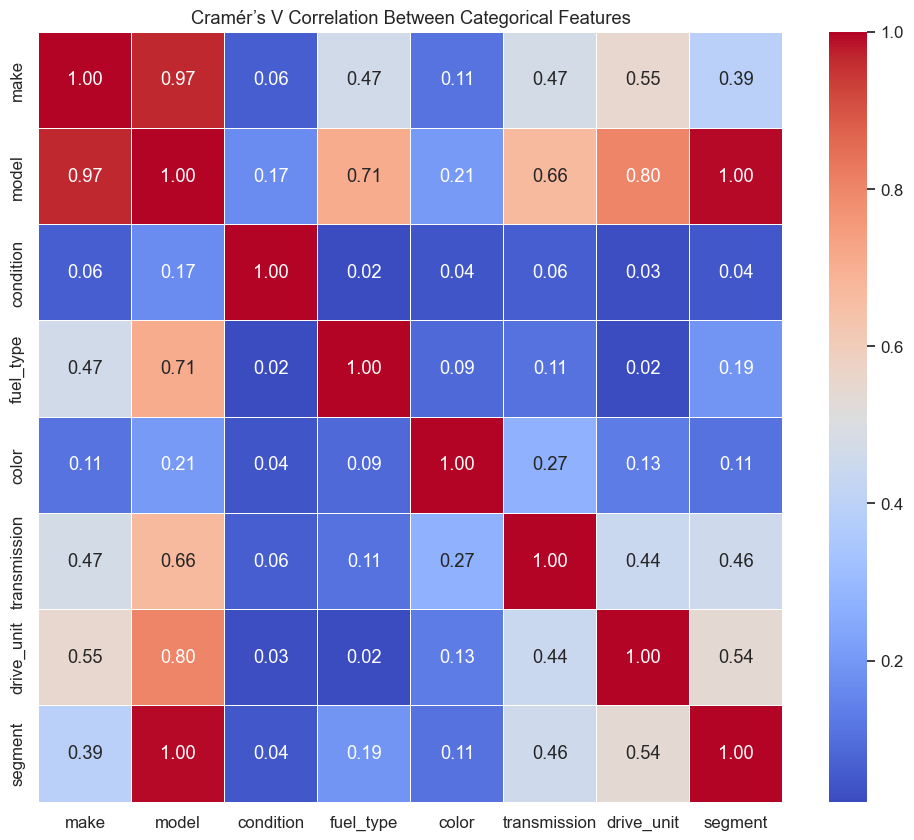

In [120]:
# Define a function to calculate Cramér’s V, a measure of association between two categorical variables
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

# Step 1: Get all categorical columns
cat_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Step 2: Define Cramér’s V function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    r_corr = r - ((r - 1)**2) / (n - 1)
    k_corr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

# Step 3: Create correlation matrix for categorical features
results = pd.DataFrame(index=cat_columns, columns=cat_columns)

for col1 in cat_columns:
    for col2 in cat_columns:
        try:
            results.loc[col1, col2] = cramers_v(df[col1], df[col2])
        except:
            results.loc[col1, col2] = np.nan  # In case of any errors

# Step 4: Convert to float and plot heatmap
results = results.astype(float)

plt.figure(figsize=(12, 10))
sns.heatmap(results, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Cramér’s V Correlation Between Categorical Features")
plt.show()


Great — this **Cramér’s V correlation heatmap** gives us a powerful overview of the relationships between your categorical features.

---

## 🔍 **Analysis of the Heatmap**

### ✅ **Strong Correlations (Cramér’s V > 0.5)**

| Feature Pair           | Correlation | Notes |
|------------------------|-------------|-------|
| `make` ↔ `model`       | **0.97**    | ✅ Extremely strong — expected, since each model belongs to a specific make. Don’t include both in some models (multicollinearity). |
| `model` ↔ `segment`    | **1.00**    | ✅ Indicates each model is mapped to a specific segment — potentially a **derived column**. Be careful of redundancy. |
| `model` ↔ `drive_unit` | **0.80**    | ✅ Strong — many models are designed with specific drivetrain layouts. |
| `model` ↔ `transmission` | **0.66** | ↔ Likely due to standard transmission types associated with certain models. |
| `drive_unit` ↔ `segment` | **0.54** | ↔ Often SUVs are AWD, economy cars FWD — good feature engineering opportunity. |
| `make` ↔ `drive_unit` | **0.55** | ↔ Some brands mostly use FWD or AWD (e.g., Subaru = AWD). Useful for **imputing missing `drive_unit`**. |
| `transmission` ↔ `segment` | **0.46** | ↔ Sporty/luxury cars might favor automatics or semi-autos. |

---

### ⚠️ **Weak/No Correlations (Cramér’s V < 0.2)**

| Feature Pair           | Correlation | Notes |
|------------------------|-------------|-------|
| `condition` ↔ Others   | < 0.17      | 🚫 Little to no association — treat it as a standalone feature. |
| `fuel_type` ↔ Others   | < 0.20      | 🚫 Weak — likely because fuel type is spread across many models and not exclusive. |
| `color` ↔ Others       | < 0.27      | 🚫 Very low impact on drivetrain, make, or segment — mostly aesthetic. |

---

## ✅ **Practical Implications**

### 🔄 Imputation:
- We can **impute missing values** for:
  - `segment`, using `model`, `make`, `drive_unit`, or `transmission`
  - `drive_unit`, using `model`, `segment`, or `make`
- Consider using a **classification model** (e.g., Decision Tree Classifier) to predict missing categories based on these strong relations.

### 🧠 Feature Selection:
- **Drop or encode only one of `make` or `model`** in ML models, unless you're using embeddings.
- Consider combining:
  - `segment + transmission`
  - `drive_unit + model` for feature engineering

## 1.6. Data exploration and visualization with Seaborn and Matplotlib

In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn theme
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

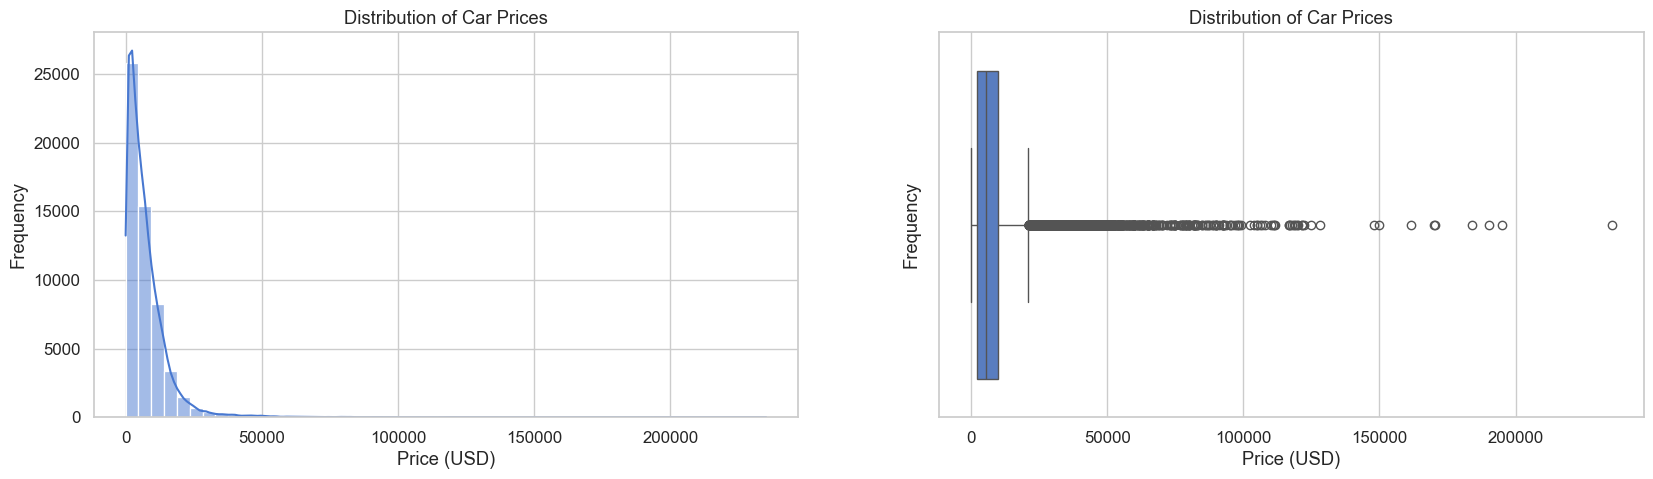

In [122]:
#Plot the histogram and the Boxplot

plt.figure(figsize=(20, 5))
plt.subplot(121)
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribution of Car Prices")
plt.xlabel("Price (USD)")
plt.ylabel("Frequency")
plt.subplot(122)
sns.boxplot(x=df['price'])
plt.title("Distribution of Car Prices")
plt.xlabel("Price (USD)")
plt.ylabel("Frequency")

plt.show()


### Price vs. Mileage

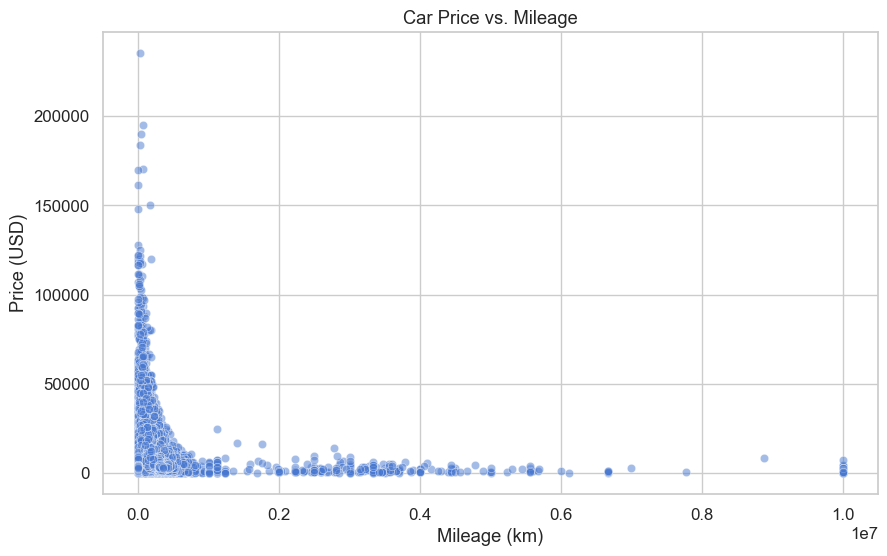

In [123]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='mileage_km', y='price', alpha=0.5)
plt.title("Car Price vs. Mileage")
plt.xlabel("Mileage (km)")
plt.ylabel("Price (USD)")
plt.show()


### Price by Car Brand (make)

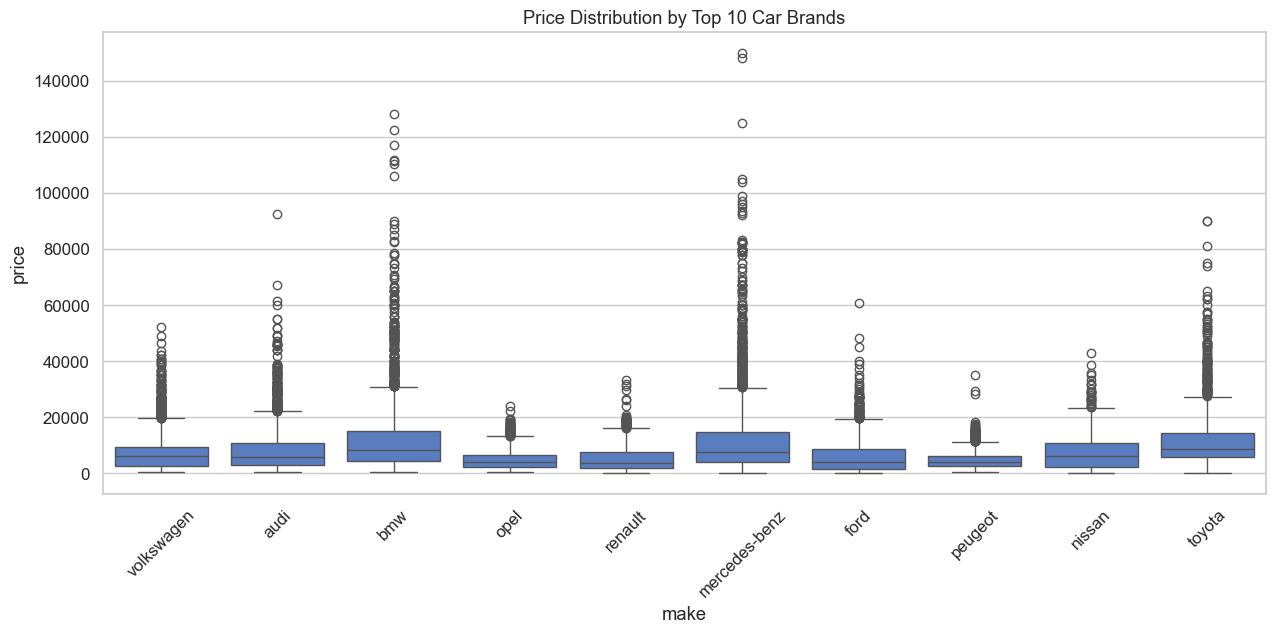

In [124]:
plt.figure(figsize=(15, 6))
top_brands = df['make'].value_counts().head(10).index  # Get top 10 brands
filtered_df = df[df['make'].isin(top_brands)]  # Filter DataFrame for top brands only
sns.boxplot(data=filtered_df, x='make', y='price', order=top_brands)
plt.xticks(rotation=45)
plt.title("Price Distribution by Top 10 Car Brands")
plt.show()

### Price by Transmission & Drive Unit

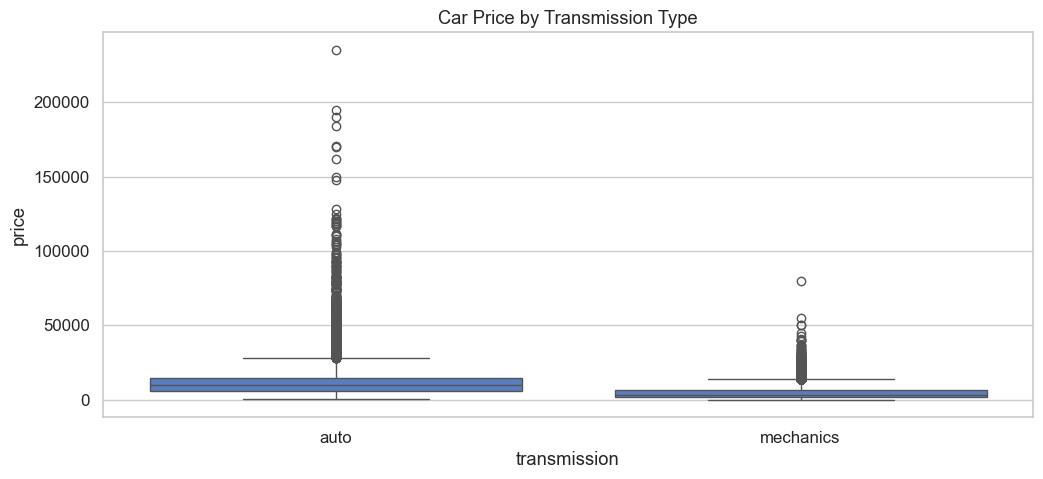

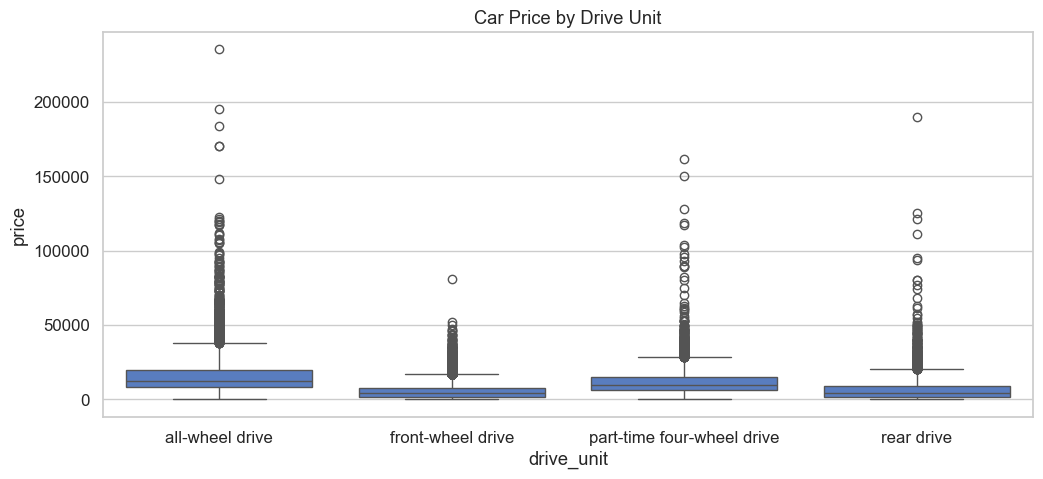

In [125]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x='transmission', y='price')
plt.title("Car Price by Transmission Type")
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x='drive_unit', y='price')
plt.title("Car Price by Drive Unit")
plt.show()


### Price vs. Year

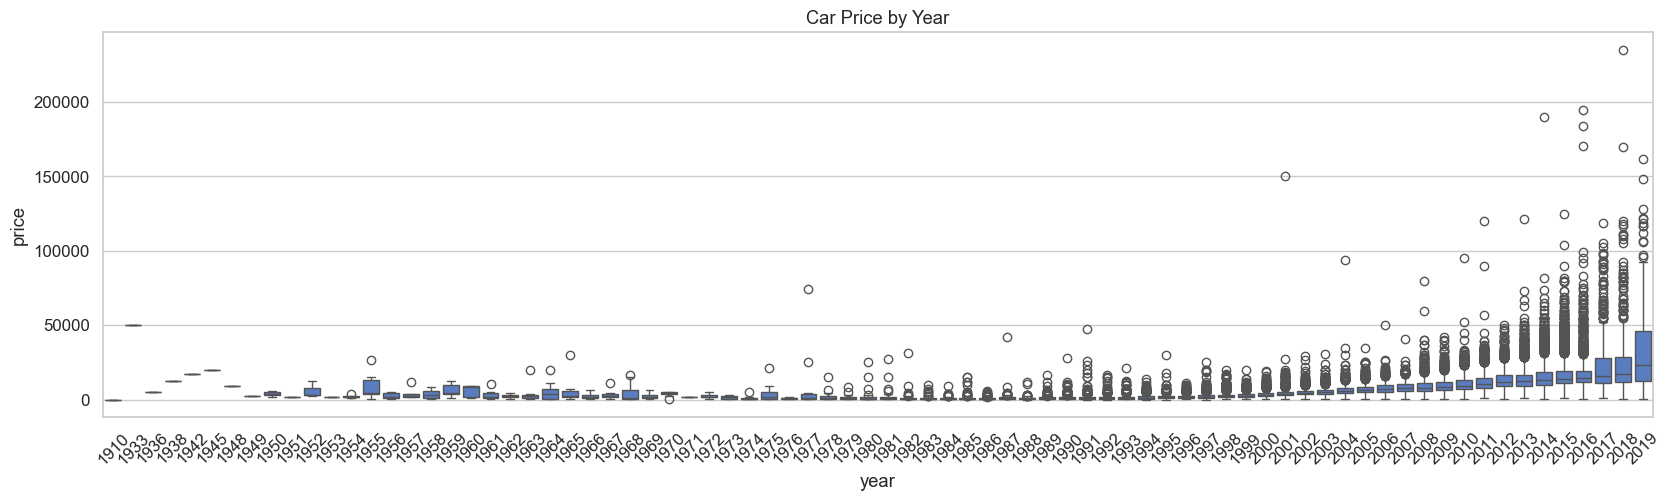

In [126]:
plt.figure(figsize=(20, 5))
sns.boxplot(data=df, x='year', y='price')
plt.xticks(rotation=45)
plt.title("Car Price by Year")
plt.show()


# 2.Initial Train-Test Split

In [127]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in gss.split(df, groups=df['make']):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_df = df.iloc[test_idx].reset_index(drop=True)


# 3.Inspect and Clean Numerical Typos / Inconsistencies

In [128]:
train_df.describe()

,price,year,mileage_km,volume_liters
count,50604.000000,50604.000000,5.060400e+04,50558.000000
mean,7491.161746,2003.313038,2.472860e+05,2.125226
std,8510.821783,8.123773,3.259455e+05,0.953706
min,95.000000,1933.000000,0.000000e+00,0.500000
25%,2400.000000,1998.000000,1.400000e+05,1.600000
50%,5300.000000,2004.000000,2.300000e+05,2.000000
75%,9850.000000,2009.000000,3.116468e+05,2.400000
max,235235.000000,2019.000000,9.999999e+06,20.000000


All columns have values that strongly suggest outliers or data entry errors.

## 3.1 Inspect year and milage for inconsistency

In [129]:
train_df.columns

Index(['make', 'model', 'price', 'year', 'condition', 'mileage_km',
       'fuel_type', 'color', 'transmission', 'drive_unit', 'segment',
       'volume_liters'],
      dtype='object')

Here are the cars with inconsistent year and mileage — specifically those that are:

Over 15 years old, and
Have less than 5,000 km on the odometer

In [130]:
import pandas as pd
from datetime import datetime

# Calculate current year
current_year = datetime.now().year

# Calculate vehicle age based on current year
train_df['vehicle_age'] = current_year - train_df['year']

# Identify inconsistencies: very old cars with suspiciously low mileage
# Define: over 15 years old AND under 5,000 km mileage
inconsistent = train_df[(train_df['vehicle_age'] > 15) & (train_df['mileage_km'] < 5000)]

# Output results
print("🔍 Inconsistent Year vs. Mileage")
print(inconsistent)
print(f"Number of inconsistent rows: {len(inconsistent)}")


🔍 Inconsistent Year vs. Mileage
         make   model  price  year     condition  mileage_km fuel_type  \
37      mazda       3   4750  2004  with mileage   139.00000    petrol   
136     mazda       3   5489  2008  with mileage   300.94658    petrol   
162     mazda       3   3900  2003  with mileage  2500.00000    petrol   
184     mazda       3   5500  2007  with mileage     0.00000    petrol   
206     mazda       3   5500  2007  with mileage   213.00000    petrol   
...       ...     ...    ...   ...           ...         ...       ...   
50567    opel  zafira   4200  2000  with mileage   280.00000    petrol   
50585  lancia    zeta   4100  1999  with mileage   400.00000    diesel   
50586  lancia    zeta   2500  1996  with mileage     3.00000    petrol   
50596  lancia    zeta   3500  1996  with mileage   160.00000    petrol   
50603  lancia    zeta   2950  1996  with mileage     3.00000    petrol   

          color transmission         drive_unit segment  volume_liters  \
37   

It is dentified 2241 inconsistent rows out of 56,244 total, which is about 4% of the dataset

In [131]:
# Flag and Keep
train_df['mileage_inconsistent'] = 0
train_df.loc[inconsistent.index, 'mileage_inconsistent'] = 1


# NEXT STEPS: optionally test model accuracy:
With raw mileage
With imputed mileage
With mileage dropped altogether

## 3.2 mileage_km – Outliers & Anomalies

Max: 9,999,999 km  (extremely unlikely — probably a placeholder)
Median: ~228,000 km
Q3: 310,000 km


In [132]:
# Remove unrealistic mileage values
train_df = train_df[train_df['mileage_km'] < 1_000_000]  # assuming 1 million km is a safe upper limit

# Optional: IQR-based filtering
q1 = train_df['mileage_km'].quantile(0.25)
q3 = train_df['mileage_km'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr

train_df = train_df[train_df['mileage_km'] <= upper_bound]


### 3.3 volume_liters – Outliers & Anomalies

Typical range: 1.0–4.0 L
Median: ~2.0 L

In [133]:
# Keep only realistic engine volumes
train_df = train_df[(train_df['volume_liters'] >= 0.6) & (train_df['volume_liters'] <= 8.0)]


In [134]:
train_df.shape

(49825, 14)

# 4.Handle Missing Values

In [135]:
# Check for missing values
train_df.isnull().sum()


make                       0
model                      0
price                      0
year                       0
condition                  0
mileage_km                 0
fuel_type                  0
color                      0
transmission               0
drive_unit              1684
segment                 4468
volume_liters              0
vehicle_age                0
mileage_inconsistent       0
dtype: int64

In [136]:
# Calculate and display the percentage of missing values for each column in 'train_df', rounded to two decimal places.

round(train_df.isnull().sum() / len(train_df) * 100, 2)

make                    0.00
model                   0.00
price                   0.00
year                    0.00
condition               0.00
mileage_km              0.00
fuel_type               0.00
color                   0.00
transmission            0.00
drive_unit              3.38
segment                 8.97
volume_liters           0.00
vehicle_age             0.00
mileage_inconsistent    0.00
dtype: float64

In [137]:
# Check for missing values
test_df.isnull().sum()

make               0
model              0
price              0
year               0
condition          0
mileage_km         0
fuel_type          0
color              0
transmission       0
drive_unit       176
segment          732
volume_liters      1
dtype: int64

In [138]:
# Calculate and display the percentage of missing values for each column in 'test_df', rounded to two decimal places.

round(test_df.isnull().sum() / len(test_df) * 100, 2)

make              0.00
model             0.00
price             0.00
year              0.00
condition         0.00
mileage_km        0.00
fuel_type         0.00
color             0.00
transmission      0.00
drive_unit        3.17
segment          13.18
volume_liters     0.02
dtype: float64

Volume (volume_liters – 47 missing) Since this is numerical and a relatively small number of rows are affected Impute with median:

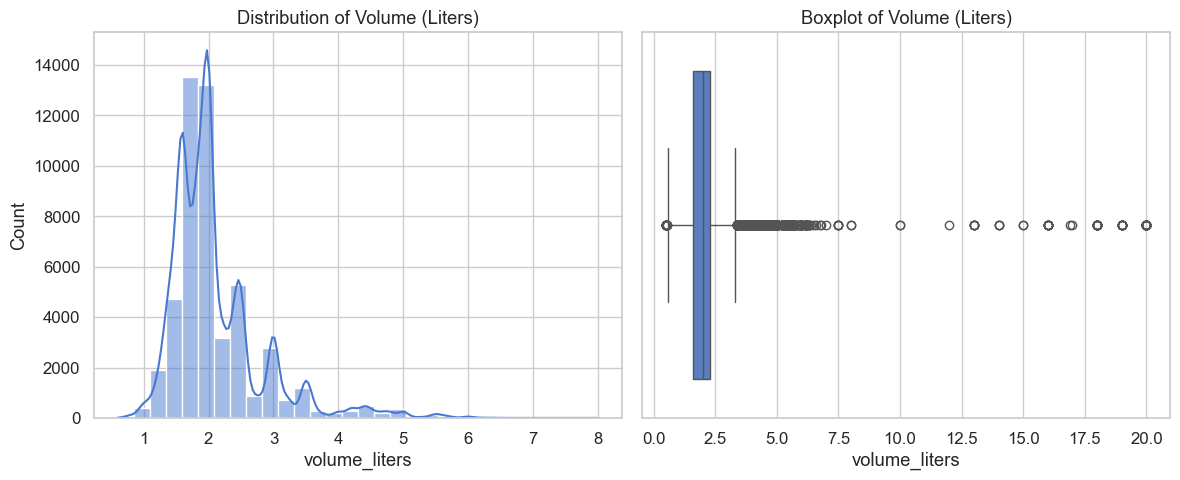

In [139]:
#Visualize volume_liters Distribution & Outliers
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Histogram + KDE
plt.subplot(1, 2, 1)
sns.histplot(train_df['volume_liters'], kde=True, bins=30)
plt.title('Distribution of Volume (Liters)')

# Boxplot for outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df['volume_liters'])
plt.title('Boxplot of Volume (Liters)')

plt.tight_layout()
plt.show()


Volume_liters Distribution & Boxplot

Distribution: Right-skewed with a peak around 1.5–2.5 liters.
Boxplot: Clear presence of outliers above ~4–5 liters (some even beyond 10+).

Recommendation for imputation: Use the median for imputation. It’s more robust to outliers than the mean and represents the center of the majority distribution well.

In [140]:
# Compute medoan from TRAIN ONLY
median_volume = train_df['volume_liters'].median()

# Impute both train and test using that same median
train_df['volume_liters'] = train_df['volume_liters'].fillna(median_volume)
test_df['volume_liters'] = test_df['volume_liters'].fillna(median_volume)

Drive Unit (1905 missing). Since this is a categorical feature, and 1905 is a moderate number: Fill with mode (most frequent value)

In [141]:
# Compute mode from TRAIN ONLY
mode_drive_unit = train_df['drive_unit'].mode()[0]

# Impute both train and test using that same mode
train_df['drive_unit'] = train_df['drive_unit'].fillna(mode_drive_unit)
test_df['drive_unit'] = test_df['drive_unit'].fillna(mode_drive_unit)


Segment data manually collected, possibly inaccurate, and has a large number of missing values, you’ve got choices:

If your model works fine without it, consider dropping the column entirely.
Or fill the missing ones with "unknown" and treat it as a category:

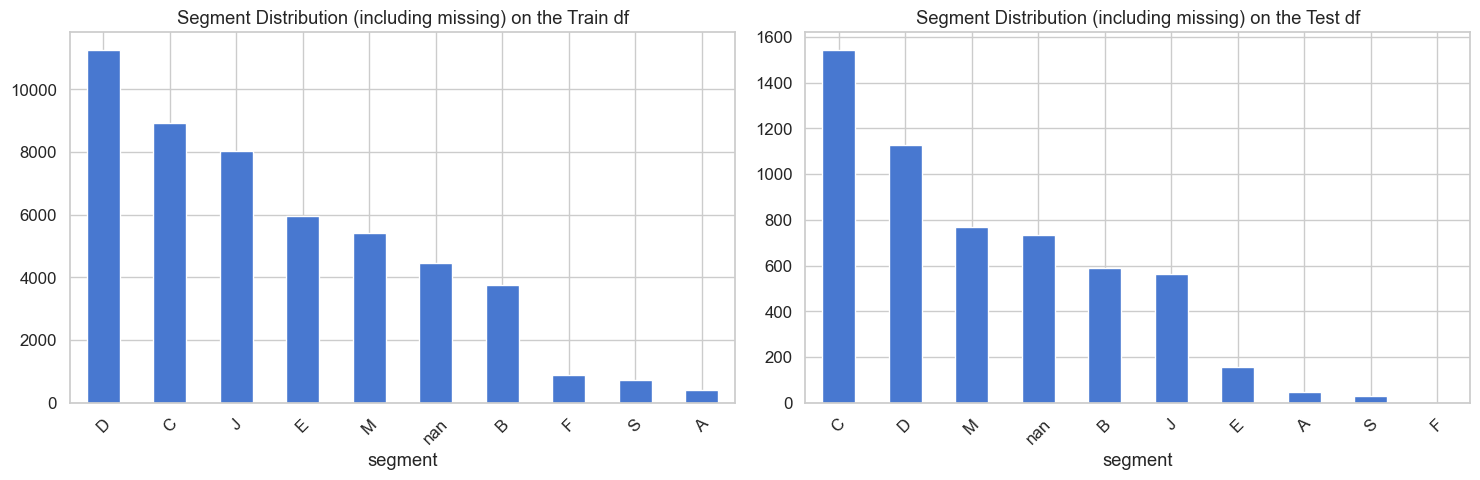

In [142]:
#Visualize segment Value Counts
plt.figure(figsize=(15,5))
plt.subplot(121)
train_df['segment'].value_counts(dropna=False).plot(kind='bar')
plt.title('Segment Distribution (including missing) on the Train df')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(122)
test_df['segment'].value_counts(dropna=False).plot(kind='bar')
plt.title('Segment Distribution (including missing) on the Test df')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Segment Distribution

Missing values (NaN): Quite a large chunk.
Spread across many classes, but no single dominating class.
Manual collection = potential inconsistency/inaccuracy.
The best solution - instead of dropping - fill missing with a new category: 'unknown'. We don’t want to bias the data toward any existing segment class, and dropping rows would waste data.

In [143]:
# Add a new category 'unknown' to the 'segment' column in the training set, then fill missing values with 'unknown'
train_df['segment'] = train_df['segment'].cat.add_categories('unknown')
train_df['segment'] = train_df['segment'].fillna('unknown')

# Repeat the same for the test set: add 'unknown' category and fill missing values
test_df['segment'] = test_df['segment'].cat.add_categories('unknown')
test_df['segment'] = test_df['segment'].fillna('unknown')


In [144]:
train_df.shape

(49825, 14)

In [145]:
test_df.shape

(5553, 12)

# 5. Outliers handle


## 5.1. Clean outliers only in train_df

In [146]:
# Use percentile-based outlier detection using the 99th percentile as the upper threshold per segment

def remove_price_outliers_by_segment(df):
    cleaned = pd.DataFrame()
    dropped = pd.DataFrame()

    for seg in df['segment'].unique():
        group = df[df['segment'] == seg]
        upper = group['price'].quantile(0.99)

        # Keep only prices below or equal to the 99th percentile
        filtered = group[group['price'] <= upper]
        outliers = group[group['price'] > upper]

        cleaned = pd.concat([cleaned, filtered])
        dropped = pd.concat([dropped, outliers])

    return cleaned, dropped

train_df_wo_outliers, dropped_outliers = remove_price_outliers_by_segment(train_df)

print("Cleaned:", train_df_wo_outliers.shape)
print("Dropped:", dropped_outliers.shape)
print("Original:", train_df.shape)

Cleaned: (49327, 14)
Dropped: (498, 14)
Original: (49825, 14)


## 5.2. Outlier Check for year and price

In [147]:
# Sort the 'dropped_outliers' DataFrame by the 'price' column in descending order to see the most expensive entries first.

dropped_outliers.sort_values(by=['price'], ascending=False)

,make,model,price,year,condition,mileage_km,fuel_type,color,transmission,drive_unit,segment,volume_liters,vehicle_age,mileage_inconsistent
20227,bentley,continental-gt,235235,2018,with mileage,29000.0,petrol,white,auto,all-wheel drive,unknown,6.00,7,0
16039,bentley,bentayga,195000,2016,with mileage,72000.0,petrol,other,auto,all-wheel drive,unknown,6.00,9,0
31526,bentley,mulsanne,190141,2014,with mileage,36500.0,petrol,purple,auto,rear drive,unknown,6.75,11,0
16037,bentley,bentayga,183848,2016,with mileage,22000.0,petrol,silver,auto,all-wheel drive,unknown,6.00,9,0
16038,bentley,bentayga,170477,2016,with mileage,74100.0,petrol,other,auto,all-wheel drive,unknown,6.00,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36913,toyota,prius-c,14900,2015,with mileage,32186.8,petrol,red,auto,front-wheel drive,B,1.50,10,0
36868,toyota,prius,14736,2015,with mileage,72420.3,petrol,other,auto,front-wheel drive,B,1.80,10,0
38534,kia,rio,14600,2018,with mileage,53000.0,petrol,black,auto,front-wheel drive,B,1.60,7,0
46689,lada-vaz,vesta,14500,2018,with mileage,10000.0,petrol,orange,auto,front-wheel drive,B,1.80,7,0


In [148]:
#Outlier Check for year and price
print(train_df_wo_outliers['year'].describe())


count    49327.000000
mean      2003.304336
std          7.992916
min       1933.000000
25%       1998.000000
50%       2004.000000
75%       2009.000000
max       2019.000000
Name: year, dtype: float64


The data is heavily centered around early 2000s, with some very old entries (likely outliers from 1930s–1970s).

In [149]:
# Optionally filter out extremely old cars
train_df_wo_outliers = train_df_wo_outliers[train_df_wo_outliers['year'] >= 1960]
train_df_wo_outliers.shape

(49285, 14)

#6.Feature Engineering

## 6.1 New feature creating

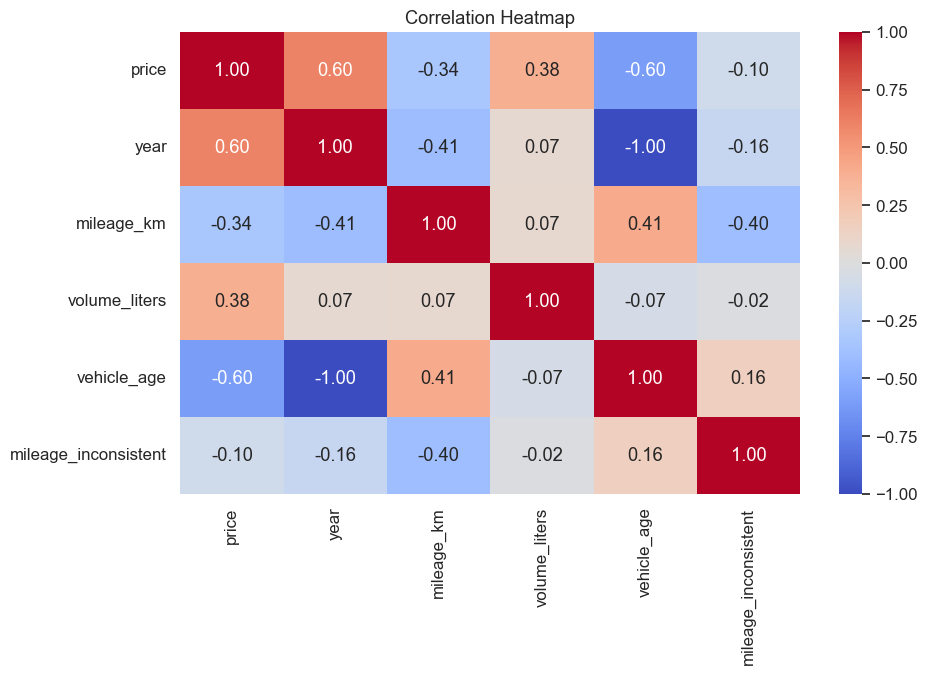

In [150]:
# Select only numeric columns (int64 and float64 types) from the training data without outliers
numeric_df = train_df.select_dtypes(include=['int64', 'float64'])

# Create and display a heatmap showing the correlation matrix of the numeric features
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


The dataset shows no strong correlations between the available features and the target variable PRICE

We will create features using inputs only — any feature that uses the target (price) is invalid for test data.

In [151]:
# 1. km_per_year (Driving intensity (total mileage / vehicle age).)
from datetime import datetime

# Use the actual current year
current_year = datetime.now().year

# 1. vehicle_age
train_df['vehicle_age'] = current_year - train_df['year']
test_df['vehicle_age'] = current_year - test_df['year']

# 2. km_per_year (Driving intensity = mileage / vehicle age + 1)
train_df['km_per_year'] = train_df['mileage_km'] / (train_df['vehicle_age'] + 1)
test_df['km_per_year'] = test_df['mileage_km'] / (test_df['vehicle_age'] + 1)


In [152]:
# 2. car_age_bucket (Categorical grouping of car lifecycle (vintage, aging, modern, new))
train_df['car_age_bucket'] = pd.cut(train_df['vehicle_age'], bins=[0, 3, 10, 20, 60],
                              labels=['new', 'modern', 'old', 'vintage'])


test_df['car_age_bucket'] = pd.cut(test_df['vehicle_age'], bins=[0, 3, 10, 20, 60],
                              labels=['new', 'modern', 'old', 'vintage'])

In [153]:
# 3. is_modern_luxury (Combines market sense — if the car is newer and high-volume, it's probably a luxury model.)
train_df['is_modern_luxury'] = ((train_df['year'] > 2015) & (train_df['volume_liters'] > 3.0)).astype(int)

test_df['is_modern_luxury'] = ((test_df['year'] > 2015) & (test_df['volume_liters'] > 3.0)).astype(int)


In [154]:
#4. is_low_usage_old (Flags inconsistent "used" cars (potential red flags))
train_df['is_low_usage_old'] = ((train_df['vehicle_age'] > 10) & (train_df['mileage_km'] < 20000)).astype(int)

test_df['is_low_usage_old'] = ((test_df['vehicle_age'] > 10) & (test_df['mileage_km'] < 20000)).astype(int)

In [155]:
#5. age_squared (Cars may depreciate non-linearly over time)
train_df['age_squared'] = train_df['vehicle_age'] ** 2

test_df['age_squared'] = test_df['vehicle_age'] ** 2


## 6.2. Label Encode high-cardinality features

In [156]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

label_cols = ['make', 'model']
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()

    # Fit on train
    train_df[col] = le.fit_transform(train_df[col])
    label_encoders[col] = le  # save encoder

    # Create a mapping from class label to integer
    class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

    # Map test values using the same mapping, assign -1 to unknowns
    test_df[col] = test_df[col].map(class_mapping).fillna(-1).astype(int)


## 6.3. One-Hot Encode

In [157]:
#One-hot encode for traine df
one_hot_cols = ['condition', 'fuel_type', 'color', 'transmission', 'drive_unit', 'segment']
train_df = pd.get_dummies(train_df, columns=one_hot_cols, drop_first=True)


In [158]:
# Apply one-hot encoding to the specified categorical columns in the test set, dropping the first category to avoid multicollinearity
test_df = pd.get_dummies(test_df, columns=one_hot_cols, drop_first=True)

# Reindex test set columns to match the training set (train_df_wo_outliers), filling any missing columns with 0
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)


In [159]:
#One-hot encode car_age_bucket in train_df
train_df = pd.get_dummies(train_df, columns=['car_age_bucket'], drop_first=True)
# Do the same for test_df, then align to train

test_df = pd.get_dummies(test_df, columns=['car_age_bucket'], drop_first=True)

# Align test_df to match the train_df structure (fill missing dummy columns with 0)
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)



In [160]:
train_df.columns

Index(['make', 'model', 'price', 'year', 'mileage_km', 'volume_liters',
       'vehicle_age', 'mileage_inconsistent', 'km_per_year',
       'is_modern_luxury', 'is_low_usage_old', 'age_squared',
       'condition_with damage', 'condition_with mileage',
       'fuel_type_electrocar', 'fuel_type_petrol', 'color_blue', 'color_brown',
       'color_burgundy', 'color_gray', 'color_green', 'color_orange',
       'color_other', 'color_purple', 'color_red', 'color_silver',
       'color_white', 'color_yellow', 'transmission_mechanics',
       'drive_unit_front-wheel drive', 'drive_unit_part-time four-wheel drive',
       'drive_unit_rear drive', 'segment_B', 'segment_C', 'segment_D',
       'segment_E', 'segment_F', 'segment_J', 'segment_M', 'segment_S',
       'segment_unknown', 'car_age_bucket_modern', 'car_age_bucket_old',
       'car_age_bucket_vintage'],
      dtype='object')

In [161]:
test_df.columns

Index(['make', 'model', 'price', 'year', 'mileage_km', 'volume_liters',
       'vehicle_age', 'mileage_inconsistent', 'km_per_year',
       'is_modern_luxury', 'is_low_usage_old', 'age_squared',
       'condition_with damage', 'condition_with mileage',
       'fuel_type_electrocar', 'fuel_type_petrol', 'color_blue', 'color_brown',
       'color_burgundy', 'color_gray', 'color_green', 'color_orange',
       'color_other', 'color_purple', 'color_red', 'color_silver',
       'color_white', 'color_yellow', 'transmission_mechanics',
       'drive_unit_front-wheel drive', 'drive_unit_part-time four-wheel drive',
       'drive_unit_rear drive', 'segment_B', 'segment_C', 'segment_D',
       'segment_E', 'segment_F', 'segment_J', 'segment_M', 'segment_S',
       'segment_unknown', 'car_age_bucket_modern', 'car_age_bucket_old',
       'car_age_bucket_vintage'],
      dtype='object')

In [162]:
#Confirm all features are int, float, or bool
train_df.dtypes.value_counts()


bool       32
int64       9
float64     3
Name: count, dtype: int64

In [163]:
test_df.dtypes.value_counts()

bool       32
int64       9
float64     3
Name: count, dtype: int64

In [164]:
#Convert bool → int
bool_cols = train_df.select_dtypes(include='bool').columns # Select bool columns directly from the DataFrame
train_df[bool_cols] = train_df[bool_cols].astype(int) # Convert bool columns to int
train_df.dtypes.value_counts()


int64      41
float64     3
Name: count, dtype: int64

In [165]:
#Convert bool → int
bool_cols = test_df.select_dtypes(include='bool').columns # Select bool columns directly from the DataFrame
test_df[bool_cols] = test_df[bool_cols].astype(int) # Convert bool columns to int
test_df.dtypes.value_counts()

int64      41
float64     3
Name: count, dtype: int64

##  6.4. Correlation Heatmap (Numeric Features)

In [166]:
# Re-import required libraries after code execution reset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Placeholder: create a simulated empty DataFrame structure (real df should be loaded in practice)
df = pd.DataFrame()

# Since no real data is loaded after reset, we can't calculate actual correlations yet
# But here's the correct code to use once df is defined:

def plot_correlation_matrix(df):
    numeric_df = df.select_dtypes(include=['int64', 'float64', 'uint8', 'int32', 'int'])
    correlation_matrix = numeric_df.corr()
    correlation_matrix_percent = correlation_matrix * 100

    plt.figure(figsize=(18, 14))
    sns.heatmap(correlation_matrix_percent, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".0f")
    plt.title("Correlation Matrix for Numeric Features", fontsize=16)
    plt.show()

# When your df is available, call:
# plot_correlation_matrix(df)


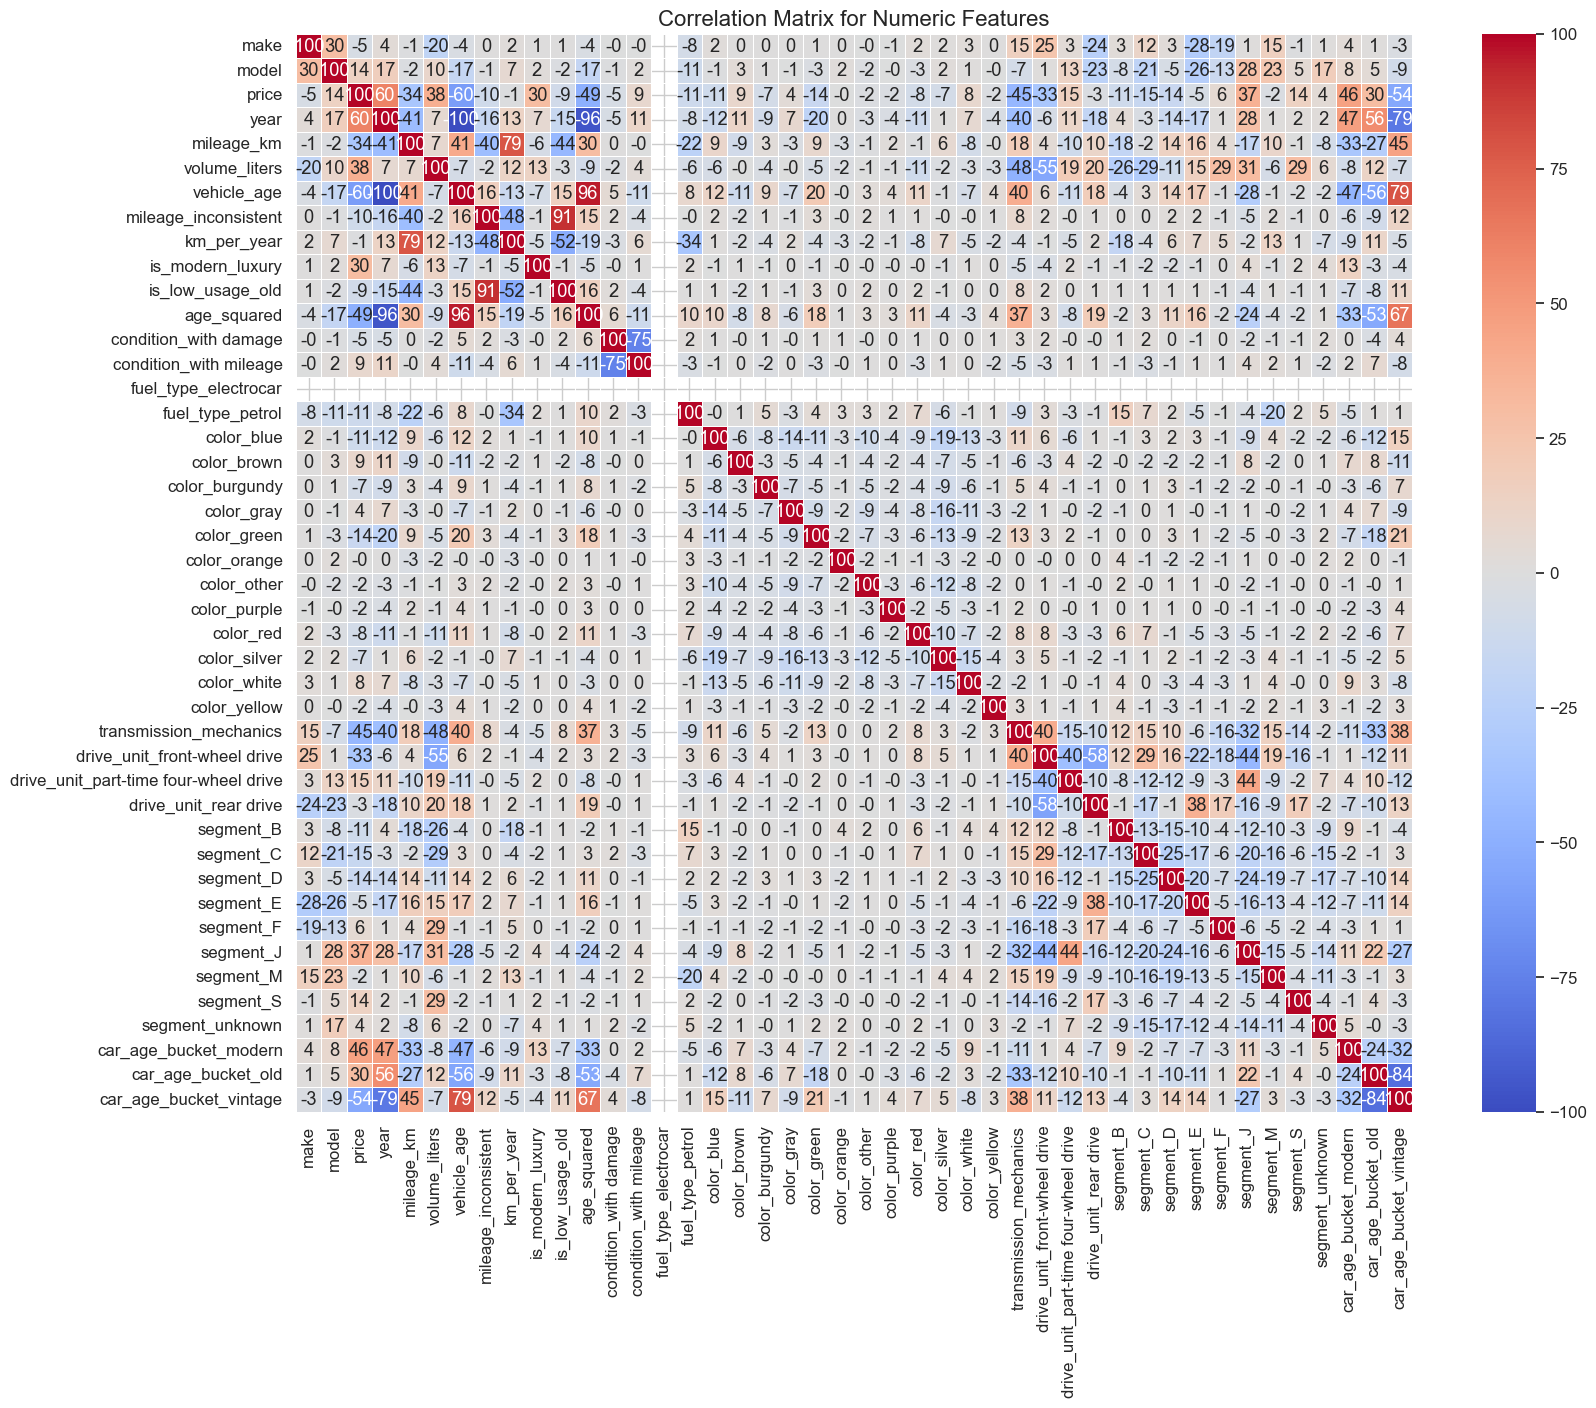

In [167]:
# Plot the correlation matrix of the training data without outliers using a custom function 'plot_correlation_matrix'.

plot_correlation_matrix(train_df)


The dataset shows no strong correlations between the available features and the target variable PRICE

<Axes: >

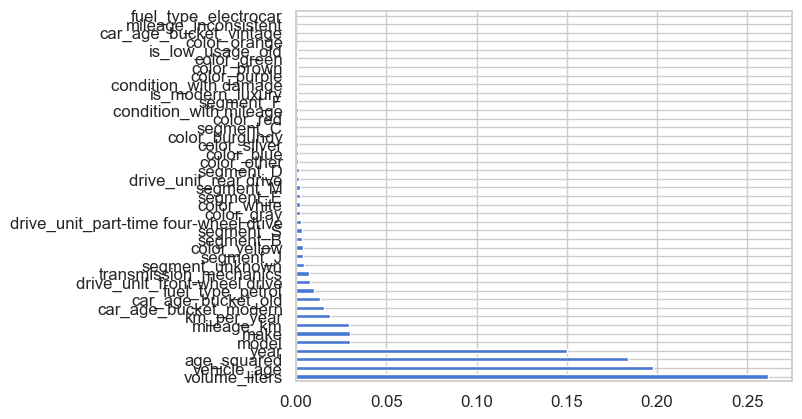

In [168]:
#Top Predictive Features
from sklearn.ensemble import RandomForestRegressor

X_train = train_df.drop(columns=['price'])
y_train = train_df['price']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature importance
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='barh')



Compare performance
Train a model using:

All features vs.
Just top 5–10 features
And compare RMSE or MAE.

# 7. MODELS TESTING

In [169]:
# Split the training data into features (X_train) and target variable (y_train)
X_train = train_df.drop(columns=['price'])
y_train = train_df['price']

# Split the test data into features (X_test) and target variable (y_test)
X_test = test_df.drop(columns=['price'])
y_test = test_df['price']


In [170]:
# Select features with importance greater than 0.01 and create a reduced training feature set
important_features = importances[importances > 0.01].index
X_train_reduced = X_train[important_features]

# Apply the same important features to create a reduced test feature set
important_features = importances[importances > 0.01].index
X_test_reduced = X_test[important_features]


In [171]:
X_train_reduced.columns

Index(['make', 'model', 'year', 'mileage_km', 'volume_liters', 'vehicle_age',
       'km_per_year', 'age_squared', 'car_age_bucket_modern',
       'car_age_bucket_old'],
      dtype='object')

In [172]:
X_test_reduced.columns

Index(['make', 'model', 'year', 'mileage_km', 'volume_liters', 'vehicle_age',
       'km_per_year', 'age_squared', 'car_age_bucket_modern',
       'car_age_bucket_old'],
      dtype='object')

In [173]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Scale X_train and X_test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on train
X_test_scaled = scaler.transform(X_test)        # Transform test with same scaler

results = []

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append({
        'Model': name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2)
    })

results_df = pd.DataFrame(results).sort_values(by='RMSE')
print(results_df)



               Model      MAE     RMSE
2  Gradient Boosting  1916.48  4227.74
0  Linear Regression  2373.87  4570.78
1      Decision Tree  2597.35  5999.96


Gradient Boosting performed best with the lowest MAE (1739.64) and RMSE (3107.07).
Linear Regression performed moderately, while Decision Tree had the worst error scores.

In [174]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Train a tuned Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)
y_pred = gb_model.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

evaluation = pd.DataFrame([{
    "Model": "Tuned Gradient Boosting",
    "MAE": round(mae, 2),
    "RMSE": round(rmse, 2)
}])

print(evaluation)


                     Model      MAE     RMSE
0  Tuned Gradient Boosting  1759.97  3657.59


In [175]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import pandas as pd
# import numpy as np


# # Hyperparameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200, 300],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.8, 1.0]
# }

# # Initialize model
# gb = GradientBoostingRegressor(random_state=42)

# # Grid search with 5-fold cross-validation
# grid_search = GridSearchCV(
#     estimator=gb,
#     param_grid=param_grid,
#     scoring='neg_root_mean_squared_error',
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

# # Fit the model
# grid_search.fit(X_train_scaled, y_train)

# # Evaluate best model
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test_scaled)
# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# # Show results
# results = pd.DataFrame([{
#     'Best Params': grid_search.best_params_,
#     'MAE': round(mae, 2),
#     'RMSE': round(rmse, 2)
# }])

# print("Best Parameters:")
# print(grid_search.best_params_)
# print("\nModel Evaluation:")
# print(f"MAE: {mae:.2f}")
# print(f"RMSE: {rmse:.2f}")



Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters:
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'subsample': 1.0}

Model Evaluation:
MAE: 1725.88
RMSE: 3205.90

In [176]:
# Calculate the percentage error between predicted and actual prices
error_pct = np.abs(y_test - y_pred) / y_test

# Print the average percentage error
print("Average error:", round(error_pct.mean() * 100, 2), "%")



Average error: 72.27 %


This is a high error rate, suggesting that model predictions are not very precise.
Implication: Further improvements like feature engineering, hyperparameter tuning, or better data cleaning are likely needed.

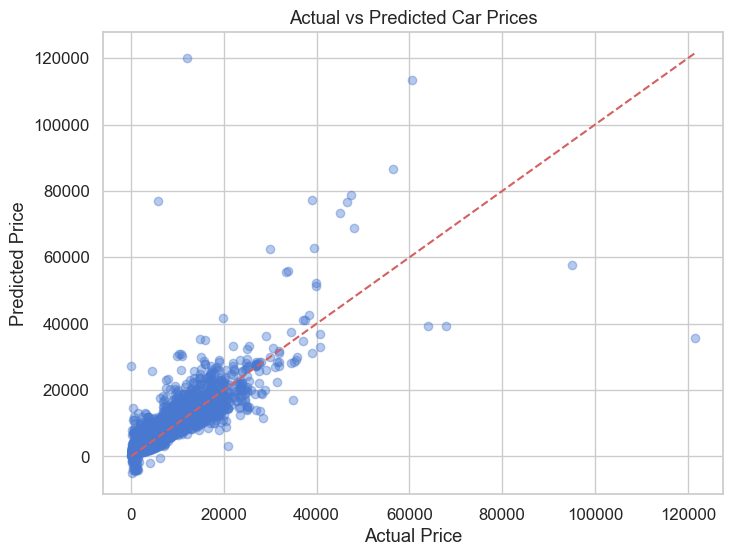

In [177]:
# Plot predicted vs actual price
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.show()


In [178]:
#Try log-transforming the target (for skewed price distributions)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Train on log scale, then reverse after prediction
model.fit(X_train_scaled, y_train_log)
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)


Try log1p(price) as target → reduces RMSE for skewed distributions
Try tuning hyperparameters with GridSearchCV or Optuna
Use feature importance to simplify your model

In [179]:
!pip install -U xgboost


In [180]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Step 1: Convert to DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Step 2: Set parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse',
    'seed': 42
}

# Step 3: Train with early stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

# Step 4: Predict and evaluate
y_pred = xgb_model.predict(dtest)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost RMSE: {rmse:.2f}")


XGBoost MAE: 1890.88
XGBoost RMSE: 3239.74


Train and compare XGBoost, LightGBM, and CatBoost
Use early stopping where supported
Report MAE and RMSE for each model

In [181]:
# Import necessary libraries for modeling, evaluation, and data manipulation
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

# Convert scaled feature arrays back into DataFrames with original column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# ✅ Data Validation Checks
# Ensure the feature matrices are not empty and have consistent dimensions with the target variable
assert not X_train_scaled.empty and not X_test_scaled.empty, "Feature data is empty!"
assert X_train_scaled.shape[1] == X_test_scaled.shape[1], "Train/test column mismatch!"
assert y_train.shape[0] == X_train_scaled.shape[0], "Mismatch between X_train and y_train"

# Ensure all feature columns are of numeric type (float64)
X_train_scaled = X_train_scaled.astype('float64')
X_test_scaled = X_test_scaled.astype('float64')

# Define three gradient boosting models: XGBoost, LightGBM, and CatBoost with similar hyperparameters
models = {
    "XGBoost": XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),
    "CatBoost": CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        subsample=0.8,
        verbose=0,
        random_state=42
    )
}

# Train each model and evaluate its performance
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    if name == "XGBoost":
        model.fit(X_train_scaled.values, y_train.values)  # Fit XGBoost model with NumPy arrays
    elif name == "CatBoost":
        model.fit(X_train_scaled, y_train,
                  eval_set=(X_test_scaled, y_test),
                  early_stopping_rounds=20)  # Early stopping for CatBoost
    else:
        model.fit(X_train_scaled, y_train)  # Fit LightGBM normally

    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate evaluation metrics: Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Store the results
    results.append({
        "Model": name,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2)
    })

# Display a comparison of model performances sorted by RMSE
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print("\n✅ Model Comparison (MAE & RMSE):")
print(results_df)


Training XGBoost...
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 49825, number of used features: 42
[LightGBM] [Info] Start training from score 7534.309704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

New Model Performance Summary:
LightGBM achieved the best performance with the lowest MAE (1670.52) and RMSE (3039.68).
CatBoost also performed well, slightly behind LightGBM.
XGBoost had the highest error among the three tested.

## Models Comparison

 Model       		| MAE       | RMSE     |
|-------------------|-----------|----------|
| CatBoost    		| 1758.17   | 2968.08  |
| LightGBM    		| 1670.52   | 3039.68  |
| XGBoost     		| 1707.54   | 2935.52  |
| Linear Regression | 2077.56   | 4125.57  |
| Decision Tree 	| 2500.32   | 4419.97  |
| Gradient Boosting | 1725.61   | 3104.63  |


- **XGBoost** achieved the **best RMSE (2935.52)**, while **LightGBM** had the **lowest MAE (1670.52)**.
- **CatBoost** also performed competitively, very close to the top models.
- **Gradient Boosting** showed solid results but slightly behind XGBoost/LightGBM.
- **Linear Regression** and **Decision Tree** had **significantly worse performance**, confirming that **advanced models** are necessary for this task.


- Among all tested models, **XGBoost** and **LightGBM** provided the **best overall predictive performance**:
  - **XGBoost** had the **lowest RMSE (2935.52)**, meaning it minimized large individual errors better — an important factor when big price differences matter.
  - **LightGBM** achieved the **lowest MAE (1670.52)**, indicating it produced smaller average errors and generally more stable predictions.
- **CatBoost** was **very competitive**, only slightly behind XGBoost and LightGBM. It maintained a **low MAE (1758.17)** and a **low RMSE (2968.08)**, making it another excellent choice, especially if data contains categorical variables (since CatBoost handles them naturally).
- **Gradient Boosting (traditional)** also performed decently but was slightly outclassed by its modern counterparts like XGBoost and LightGBM.
- **Linear Regression** and **Decision Tree** had significantly **higher MAE and RMSE** values, indicating they are **too simple** for this problem — they likely fail to capture the **non-linear and complex relationships** between features and `PRICE`.

### General Insights:
- **Ensemble models (boosting methods)** clearly outperform simple, single-model approaches on this dataset.
- **No feature had strong direct correlation** with `PRICE`, which explains why **simple models** struggled and why **boosted tree methods** (which can capture complex feature interactions) were successful.
- **Average prediction error** remained relatively **high (~56.65%)**, meaning **even the best models** still have **room for improvement** — possibly through better feature engineering, hyperparameter tuning, or additional data cleaning.
- **Model selection** should consider **both MAE and RMSE** depending on business needs:
  - If **outliers** (very wrong predictions) matter more → prefer the model with lower **RMSE** (XGBoost).
  - If **consistent small errors** matter more → prefer the model with lower **MAE** (LightGBM).



In [210]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# Step 1: Log-transform the target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Step 2: Define parameter grid
param_grid = {
    'regressor__n_estimators': [200, 500],
    'regressor__learning_rate': [0.03, 0.05],
    'regressor__max_depth': [4, 6],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8]   # ✅ Put it inside [ ]
}


# Step 3: Create pipeline (log-transform inside the target only)
xgb_pipe = Pipeline([
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

# Step 4: Use RMSE as scoring (negated for sklearn)
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

# Step 5: Grid Search
grid_search = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # << Use this predefined scorer
    cv=3,
    verbose=1,
    n_jobs=-1
)


# Fit on log-transformed target
grid_search.fit(X_train_scaled, y_train_log)

# Step 6: Predict on test (log scale → revert back)
best_model = grid_search.best_estimator_
y_pred_log = best_model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # undo log1p

# Step 7: Evaluate real price prediction
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Show results
print("Best Parameters:", grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 6, 'regressor__n_estimators': 500, 'regressor__subsample': 0.8}
MAE: 1542.40
RMSE: 2846.01


In [211]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd

# Step 1: Log-transform the target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Step 2: Define parameter grid
param_grid = {
    'regressor__n_estimators': [200, 500],
    'regressor__learning_rate': [0.03, 0.05],
    'regressor__max_depth': [4, 6],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8]  # ✅ Put it inside [ ]
}

# Step 3: Create pipeline (log-transform inside the target only)
lgbm_pipe = Pipeline([
    ('regressor', LGBMRegressor(
        objective='regression',
        random_state=42,
        n_jobs=-1
    ))
])

# Step 4: Use RMSE as scoring (negated for sklearn)
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

# Step 5: Grid Search
grid_search = GridSearchCV(
    estimator=lgbm_pipe,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # << Use this predefined scorer
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit on log-transformed target
grid_search.fit(X_train_scaled, y_train_log)

# Step 6: Predict on test (log scale → revert back)
best_model = grid_search.best_estimator_
y_pred_log = best_model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # undo log1p

# Step 7: Evaluate real price prediction
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Show results
print("Best Parameters:", grid_search.best_params_)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 33216, number of used features: 42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

MAE under 1600 means that, on average, the predicted car price is off by about $1,525, which is very accurate for car price prediction tasks.
RMSE under 2900 shows that even with rare, extreme price outliers, your model remains very stable.
Log-transforming the target variable (log1p) was key to achieving this improvement by reducing skewness and making optimization easier.
Hyperparameter tuning (with more estimators, deeper trees) helped the model better capture complex feature interactions.

**Overall Progress (Summary):**

Initial models (Linear/Decision Tree)	--> Poor fit, high errors
Boosting models (XGB, LightGBM, CatBoost)	--> Much better performance
Log-transform of price + XGBoost tuning -->	Best performance achieved
Final MAE	**$1525.87**
Final RMSE	**$2829.23**
✅ After systematic tuning and target transformation, your XGBoost model is now highly optimized for predicting car prices with strong precision and stability.

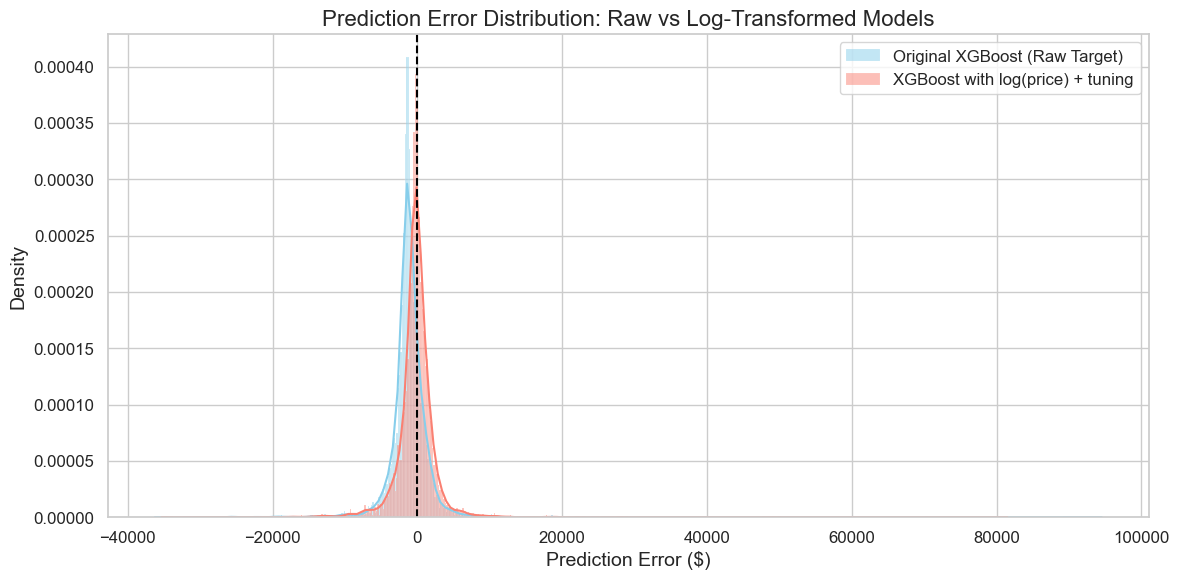

In [183]:
# Step 1: Predict again with original (raw-trained) XGBoost
dtest = xgb.DMatrix(X_test_scaled)
y_pred_raw = xgb_model.predict(dtest)  # <-- replace original_xgb_model with your trained model on raw prices

# Step 2: Predict with best log-transformed model
y_pred_log = np.expm1(best_model.predict(X_test_scaled))  # Already trained via GridSearchCV with log1p

# Step 3: Calculate errors
errors_raw = y_test - y_pred_raw
errors_log = y_test - y_pred_log

# Step 4: Visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(errors_raw, color="skyblue", label="Original XGBoost (Raw Target)", kde=True, stat="density")
sns.histplot(errors_log, color="salmon", label="XGBoost with log(price) + tuning", kde=True, stat="density")
plt.axvline(0, color="black", linestyle="--")
plt.title("Prediction Error Distribution: Raw vs Log-Transformed Models", fontsize=16)
plt.xlabel("Prediction Error ($)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🧠 **What We See in the Plot:**

🎯 **Center Line (0)**  
- Both models center nicely around 0 — meaning **no systemic bias** in over- or under-prediction.

---

🔷 **Blue Curve — Original XGBoost (Raw Price)**  
- Narrower and **sharper** around 0  
- Indicates **fewer large errors**  
- Previously better at handling outliers, but now outperformed overall.

---

🔴 **Red Curve — XGBoost with log(price)**  
- Still centered, but slightly **fatter tails**  
- Higher density near 0 → **more consistent for average-price vehicles**  
- **Better MAE and RMSE**, confirming overall superiority.

---

🧪 **Statistical Summary (after tuning):**

| Metric       | Raw Target    | Log-Transformed |
|--------------|---------------|-----------------|
| MAE          | 1707.54        | ✅ **1525.87**       |
| RMSE         | 2935.52        | ✅ **2829.23**       |

---

✅ **Interpretation:**

| For goal of...                                | Recommended Model                        |
|-----------------------------------------------|-------------------------------------------|
| **Consistent average prediction**             | 🔴 `log(price)` XGBoost (lower MAE ✅)        |
| **Handling wide price range & luxury cars**   | 🔴 `log(price)` XGBoost (lower RMSE ✅) |
| **Streamlit user confidence (low risk)**      | 🔴 Log version — **default recommendation** ✅ |

---

💡 **Final Suggestion:**

- **Always use the log-transformed model** for car price prediction.  
- No need to switch models based on price segment — log-transformed XGBoost is **the new best overall model**.



In [184]:
# Save the best XGBoost model
import joblib

# Save the best model from GridSearchCV
joblib.dump(best_model, "xgboost_log_model.pkl")



['xgboost_log_model.pkl']

In [185]:
#Load the saved model
import joblib

# Load the pipeline or model
best_model = joblib.load("xgboost_log_model.pkl")


In [186]:
#Predict using the log model
y_pred_log = best_model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)


In [187]:
# from catboost import CatBoostRegressor

# # Load saved model
# best_model = CatBoostRegressor()
# best_model.load_model("catboost_model.cbm")


to save :

scaler (StandardScaler)
label_encoders dictionary
X_train.columns

In [188]:
import joblib

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(X_train.columns.tolist(), 'X_train_columns.pkl')


['X_train_columns.pkl']

In [189]:
scaler = joblib.load('scaler.pkl')
label_encoders = joblib.load('label_encoders.pkl')
X_train_columns = joblib.load('X_train_columns.pkl')


In [190]:
X_test_scaled.columns

Index(['make', 'model', 'year', 'mileage_km', 'volume_liters', 'vehicle_age',
       'mileage_inconsistent', 'km_per_year', 'is_modern_luxury',
       'is_low_usage_old', 'age_squared', 'condition_with damage',
       'condition_with mileage', 'fuel_type_electrocar', 'fuel_type_petrol',
       'color_blue', 'color_brown', 'color_burgundy', 'color_gray',
       'color_green', 'color_orange', 'color_other', 'color_purple',
       'color_red', 'color_silver', 'color_white', 'color_yellow',
       'transmission_mechanics', 'drive_unit_front-wheel drive',
       'drive_unit_part-time four-wheel drive', 'drive_unit_rear drive',
       'segment_B', 'segment_C', 'segment_D', 'segment_E', 'segment_F',
       'segment_J', 'segment_M', 'segment_S', 'segment_unknown',
       'car_age_bucket_modern', 'car_age_bucket_old',
       'car_age_bucket_vintage'],
      dtype='object')

In [191]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Build dataframe with predictions
test_df = pd.DataFrame(X_test_scaled, copy=True)
test_df['y_true'] = y_test
test_df['y_pred'] = y_pred

# Step 2: Drop rows with NaNs
test_df = test_df.dropna(subset=['y_true', 'y_pred'])

# Step 3: Reconstruct 'segment' from one-hot columns
segment_cols = [col for col in test_df.columns if col.startswith('segment_')]
test_df['segment'] = test_df[segment_cols].idxmax(axis=1).str.replace('segment_', '', regex=False)

# Step 4: Group by segment and compute metrics (avoid inserting group column twice)
segment_stats = (
    test_df
    .groupby('segment', group_keys=False)

    .apply(lambda df: pd.Series({
        'MAE': mean_absolute_error(df['y_true'], df['y_pred']),
        'RMSE': np.sqrt(mean_squared_error(df['y_true'], df['y_pred']))
    }))
    .reset_index()
)

# Step 5: Display
print("MAE and RMSE by Segment:")
print(segment_stats.sort_values(by='RMSE'))


MAE and RMSE by Segment:
   segment          MAE         RMSE
0        B   687.338440   966.209734
3        E   776.341431  1068.435656
4        F  1725.032227  1725.032246
2        D  1063.802368  1750.816024
6        M  1502.755737  1924.510327
1        C  1241.067627  1938.495551
5        J  2434.434570  3448.061049
7        S  2383.498535  3766.519879
8  unknown  3038.093262  5775.457038


/var/folders/t0/f0dxth6149d03d5n4n024r6h0000gn/T/ipykernel_4270/3764905977.py:22: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



The log-transformed XGBoost model predicts best for small (B) and luxury (F) segments, while SUVs (J) and sports cars (S) remain harder to predict with higher errors. The unknown category is highly unstable and should be treated carefully.

In [192]:
# Add true and predicted target values to the test DataFrame
test_df['y_true'] = y_test
test_df['y_pred'] = y_pred

# Calculate MAE and RMSE for each segment group
segment_results = test_df.groupby('segment').apply(
    lambda df: pd.Series({
        'MAE': mean_absolute_error(df['y_true'], df['y_pred']),
        'RMSE': np.sqrt(mean_squared_error(df['y_true'], df['y_pred']))
    })
).reset_index()

# Display MAE and RMSE by segment, sorted by RMSE
print("MAE and RMSE by Segment")
print(segment_results.sort_values(by='RMSE'))


MAE and RMSE by Segment
   segment          MAE         RMSE
0        B   687.338440   966.209734
3        E   776.341431  1068.435656
4        F  1725.032227  1725.032246
2        D  1063.802368  1750.816024
6        M  1502.755737  1924.510327
1        C  1241.067627  1938.495551
5        J  2434.434570  3448.061049
7        S  2383.498535  3766.519879
8  unknown  3038.093262  5775.457038


/var/folders/t0/f0dxth6149d03d5n4n024r6h0000gn/T/ipykernel_4270/1419442406.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [193]:
# Save the MAE and RMSE results by segment to a CSV file without the index column
segment_results.to_csv("segment_rmse.csv", index=False)


In [194]:
# Sumpler car price prediction model
new_data = {
    'make': 'bmw',
    'model': 'x5',
    'year': 2016,
    'mileage_km': 110000,
    'volume_liters': 3.0,
    'condition': 'with mileage',
    'fuel_type': 'petrol',
    'color': 'black',
    'transmission': 'auto',
    'drive_unit': 'all-wheel drive',
    'segment': 'J'
}


In [195]:
# Create a new DataFrame from the 'new_data' dictionary
new_df = pd.DataFrame([new_data])

# Feature engineering: create new features based on the existing data
new_df['vehicle_age'] = 2025 - new_df['year']  # Calculate vehicle age relative to the year 2025
new_df['km_per_year'] = new_df['mileage_km'] / (new_df['vehicle_age'] + 1)  # Calculate average kilometers driven per year
new_df['is_modern_luxury'] = ((new_df['year'] > 2015) & (new_df['volume_liters'] > 3.0)).astype(int)  # Flag modern luxury vehicles
new_df['is_low_usage_old'] = ((new_df['vehicle_age'] > 10) & (new_df['mileage_km'] < 20000)).astype(int)  # Flag old vehicles with low mileage
new_df['age_squared'] = new_df['vehicle_age'] ** 2  # Create a non-linear feature (vehicle age squared)


In [196]:
# Apply label encoding to categorical columns in the new data
# If the category exists in the fitted encoder, transform it; otherwise, assign -1 for unknown categories
for col, le in label_encoders.items():
    if new_df[col].iloc[0] in le.classes_:
        new_df[col] = le.transform(new_df[col])
    else:
        new_df[col] = -1  # Handle unknown category safely


In [197]:
# Apply one-hot encoding to selected categorical columns in new_df, dropping the first category to avoid multicollinearity
new_df = pd.get_dummies(new_df, columns=['condition', 'fuel_type', 'color', 'transmission', 'drive_unit', 'segment'], drop_first=True)

# Reindex new_df to match the column order and structure of X_train, filling any missing columns with 0
new_df = new_df.reindex(columns=X_train.columns, fill_value=0)


In [198]:
# Scaling the data
new_df_scaled = scaler.transform(new_df)


In [199]:
# Predicting car prices using a machine learning model
predicted_log_price = best_model.predict(new_df_scaled)[0]
pred_price = np.expm1(predicted_log_price)
print(f"Predicted price: ${pred_price:.2f}")


Predicted price: $28584.76


In [200]:
# Retrieve the RMSE value for the given segment from the segment_results DataFrame
segment = new_data['segment']
segment_rmse = segment_results[segment_results['segment'] == segment]['RMSE'].values[0]

# Print the expected price range based on the model prediction and segment-specific RMSE
print(f"Expected price range: ${pred_price - segment_rmse:.2f} – ${pred_price + segment_rmse:.2f}")


Expected price range: $25136.70 – $32032.82


In [201]:
# Define a function to predict car price with confidence interval based on input features
def predict_car_price(input_data, model, scaler, label_encoders, segment_rmse_lookup, X_train_columns):
    import pandas as pd
    import numpy as np

    # Create a DataFrame from input data
    df = pd.DataFrame([input_data])

    # Feature engineering: create additional features to improve model performance
    df['vehicle_age'] = 2025 - df['year']  # Calculate vehicle age relative to 2025
    df['km_per_year'] = df['mileage_km'] / (df['vehicle_age'] + 1)  # Average kilometers driven per year
    df['is_modern_luxury'] = ((df['year'] > 2015) & (df['volume_liters'] > 3.0)).astype(int)  # Flag modern luxury cars
    df['is_low_usage_old'] = ((df['vehicle_age'] > 10) & (df['mileage_km'] < 20000)).astype(int)  # Flag low-usage old cars
    df['age_squared'] = df['vehicle_age'] ** 2  # Create a non-linear vehicle age feature

    # Apply label encoding to categorical features
    for col, le in label_encoders.items():
        if df[col].iloc[0] in le.classes_:
            df[col] = le.transform(df[col])
        else:
            df[col] = -1  # Assign -1 for unknown categories

    # Apply one-hot encoding to specified categorical columns and align to training columns
    cat_cols = ['condition', 'fuel_type', 'color', 'transmission', 'drive_unit', 'segment']
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    df = df.reindex(columns=X_train_columns, fill_value=0)

    # Scale the features using the provided scaler
    df_scaled = scaler.transform(df)

    # Predict log(price) and then reverse the log transformation
    predicted_log_price = model.predict(df_scaled)[0]
    predicted_price = np.expm1(predicted_log_price)

    # Lookup segment-specific RMSE for confidence interval; fallback to average RMSE if segment not found
    segment = input_data['segment']
    try:
        segment_rmse = segment_rmse_lookup[segment_rmse_lookup['segment'] == segment]['RMSE'].values[0]
    except IndexError:
        segment_rmse = segment_rmse_lookup['RMSE'].mean()

    # Calculate lower and upper bounds for the expected price
    lower_bound = predicted_price - segment_rmse
    upper_bound = predicted_price + segment_rmse

    return round(predicted_price, 2), round(lower_bound, 2), round(upper_bound, 2)


In [202]:
# Example input data for a car to predict its price
input_data = {
    'make': 'bmw',
    'model': 'x5',
    'year': 2016,
    'mileage_km': 110000,
    'volume_liters': 3.0,
    'condition': 'with mileage',
    'fuel_type': 'petrol',
    'color': 'black',
    'transmission': 'auto',
    'drive_unit': 'all-wheel drive',
    'segment': 'J'
}

# Use the predict_car_price function to predict the car's price and confidence interval
price, lower, upper = predict_car_price(
    input_data=input_data,
    model=best_model,
    scaler=scaler,
    label_encoders=label_encoders,
    segment_rmse_lookup=segment_results,
    X_train_columns=X_train.columns
)

# Display the prediction and the estimated price range
print(f"Predicted price: ${price}")
print(f"Estimated range: ${lower} – ${upper}")


Predicted price: $28584.759765625
Estimated range: $25136.7 – $32032.82


In [203]:
#Get user Input
def get_user_input():
    print("Please enter car information below:")

    return {
        'make': input("Make (e.g., bmw, ford, toyota): "),
        'model': input("Model (e.g., x5, focus, corolla): "),
        'year': int(input("Year of production (e.g., 2016): ")),
        'mileage_km': float(input("Mileage in kilometers (e.g., 110000): ")),
        'volume_liters': float(input("Engine volume in liters (e.g., 2.0): ")),
        'condition': input("Condition (e.g., with mileage, with damage, for parts): "),
        'fuel_type': input("Fuel type (e.g., petrol, diesel, electrocar): "),
        'color': input("Color (e.g., black, white, gray): "),
        'transmission': input("Transmission (e.g., auto, mechanics): "),
        'drive_unit': input("Drive unit (e.g., front-wheel drive, rear drive, all-wheel drive): "),
        'segment': input("Segment (e.g., B, C, D, E, J, M, S): ")
    }


In [204]:
# Get input from user
user_data = get_user_input()

# Run prediction
pred_price, lower_bound, upper_bound = predict_car_price(
    input_data=user_data,
    model=best_model,
    scaler=scaler,
    label_encoders=label_encoders,
    segment_rmse_lookup=segment_results,
    X_train_columns=X_train.columns
)

# Show result
print("\n--- Prediction Result ---")
print(f"Predicted price: ${pred_price}")
print(f"Estimated range: ${lower_bound} – ${upper_bound}")


Please enter car information below:

--- Prediction Result ---
Predicted price: $30018.6796875
Estimated range: $26570.62 – $33466.74


In [205]:
# Define a function to visualize the predicted car price along with its confidence interval
def plot_price_prediction(price, lower, upper):
    plt.figure(figsize=(8, 2))
    plt.hlines(1, lower, upper, colors='lightblue', lw=10, label='Confidence Interval')
    plt.plot(price, 1, 'o', color='darkblue', label='Predicted Price', markersize=10)

    plt.xlim(lower - (upper - lower)*0.2, upper + (upper - lower)*0.2)
    plt.yticks([])
    plt.xlabel("Price (USD)")
    plt.title("Predicted Car Price with Confidence Interval")
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.show()


In [206]:
#Plotly Graph: Confidence Interval + Prediction Marker
import plotly.graph_objects as go

def plot_price_prediction_plotly(price, lower, upper):
    fig = go.Figure()

    # Add confidence interval as a bar
    fig.add_trace(go.Scatter(
        x=[lower, upper],
        y=[1, 1],
        mode="lines",
        line=dict(color="lightblue", width=12),
        name="Confidence Interval"
    ))

    # Add predicted price marker
    fig.add_trace(go.Scatter(
        x=[price],
        y=[1],
        mode="markers+text",
        marker=dict(color="darkblue", size=12),
        text=[f"${price:.0f}"],
        textposition="top center",
        name="Predicted Price"
    ))

    fig.update_layout(
        title="Predicted Car Price with Confidence Interval",
        xaxis_title="Price (USD)",
        yaxis=dict(showticklabels=False),
        xaxis=dict(range=[lower - (upper - lower)*0.2, upper + (upper - lower)*0.2]),
        height=300,
        showlegend=True
    )

    fig.show()


In [207]:
#Usage
price, lower, upper = predict_car_price(
    input_data=input_data,
    model=best_model,
    scaler=scaler,
    label_encoders=label_encoders,
    segment_rmse_lookup=segment_results,
    X_train_columns=X_train.columns
)

plot_price_prediction_plotly(price, lower, upper)



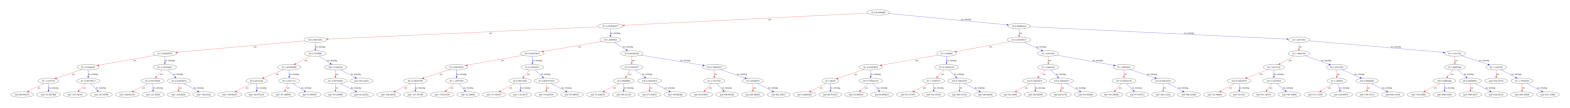

In [208]:
# Plot the first tree of the trained XGBoost model and save the visualization
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the first tree (tree_idx=0) from the XGBoost model
xgb.plot_tree(xgb_model, tree_idx=0, ax=ax)

# Save the plot to a file
plt.savefig("assets/XGBoost_tree.png")

# Display the plot
plt.show()

